# 16ML Week 6: Hierarchical Clustering

In this assignment, we will explore the theory and application of *hierarchical clustering*, a clustering algorithm that splits or joins clusters based on a flexible cluster similarlity metric until a stopping condition is satisfied.

## Algorithm Overview

Hierarchical clustering creates a tree-like structure that allows you to assign a data point to a cluster. The tree can be created from the bottom up, or from the top down. Each of these methods corresponds to a variant of hierarchical clustering; aptly named *agglomerative* and *divisive* clustering, respectively. When using the bottom-up approach, the algorithm starts with each data point in its own cluster, and successively merges the closest two clusters into one cluster until it has reached the desired number of clusters. The top-down approach does the reverse: it splits each cluster into two until the cluster can no longer be divided.

In the remainder of this problem set, we will
1. observe a demo of hierarchical clustering
2. implement each variant of hirarchical clustering, and visualize how the algorithms work
3. develop an intuition for setting hyperparameters using sklearn's [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering) or scipy's [linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) function.
4. apply hierarchical clustering in real world settings

# Part 1: Demo

In this section, we'll look at some example datasets and see how K-Means and hierarchical clustering perform on these datasets to gain an intuition for the strengths and weaknesses of each algorithm.

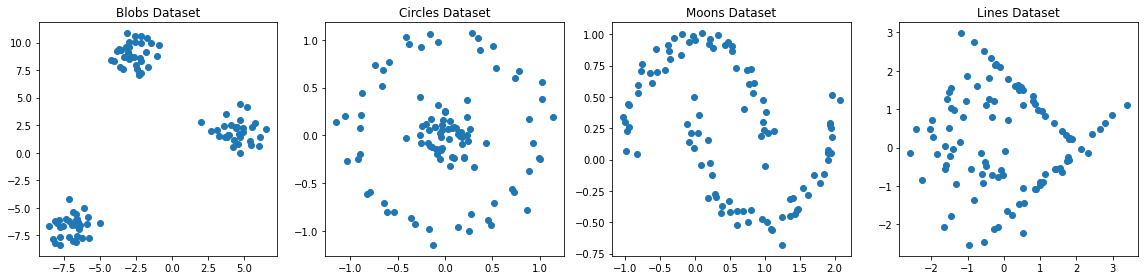

In [1]:
#@title Sample datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_circles, make_classification, make_moons

COLORS = np.array(sns.color_palette())

class Dataset:
    def __init__(self, data, title, n_clusters):
        self.data = data
        self.data.flags.writeable = False
        self.title = title
        self.n_clusters = n_clusters

    @property
    def x(self):
        return self.data[:, 0]

    @property
    def y(self):
        return self.data[:, 1]

    def plot(self, axis, coloraxis=None):
        axis.scatter(self.x, self.y, c=coloraxis)
        axis.set_title(f'{self.title} Dataset')

    def plot_clusters(self, clusterer, axis):
        pred_clusters = clusterer.fit_predict(self.data)
        self.plot(axis, coloraxis=COLORS[pred_clusters])
    

blobs_dataset = Dataset(make_blobs(centers=3, random_state=42)[0], 'Blobs', 3)
circles_dataset = Dataset(make_circles(noise=0.09, factor=.2, random_state=42)[0], 'Circles', 2)
lines_dataset = Dataset(make_classification(n_features=2, n_redundant=0, random_state=4242)[0], 'Lines', 3)
moons_dataset = Dataset(make_moons(noise=0.07)[0], 'Moons', 2)

datasets = [
  blobs_dataset,
  circles_dataset,
  moons_dataset,
  lines_dataset,
]

def plt_datasets(datasets, title=None, plotter=Dataset.plot):
    fig, axes = plt.subplots(nrows=1,
                           ncols=len(datasets),
                           figsize=(4*len(datasets), 4))
    for (dataset, axis) in zip(datasets, axes):
        plotter(dataset, axis)
    fig.suptitle(title)
    fig.tight_layout()

plt_datasets(datasets)

## K-Means

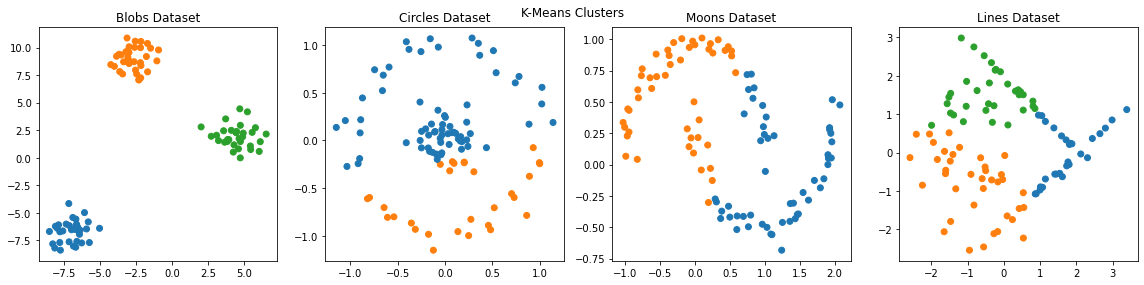

In [2]:
#@title K-Means Clusters
from sklearn.cluster import KMeans
plt_datasets(datasets,
             title='K-Means Clusters',
             plotter=lambda dataset, axis: dataset.plot_clusters(
                 KMeans(n_clusters=dataset.n_clusters), axis))

As we may expect, K-Means works well when its assumptions are followed: the clusters are well separated blobs in Euclidean space. However, that only applies to the first dataset.

For the second _Circles_ dataset, you could consider using the kernel K-Means algorithm that you designed on the previous homework, but the _Moons_ and _Lines_ datasets would require challenging kernel functions. What if we could use a different algorithm entirely? How about heirarchical clustering?

## Hierarchical Clustering

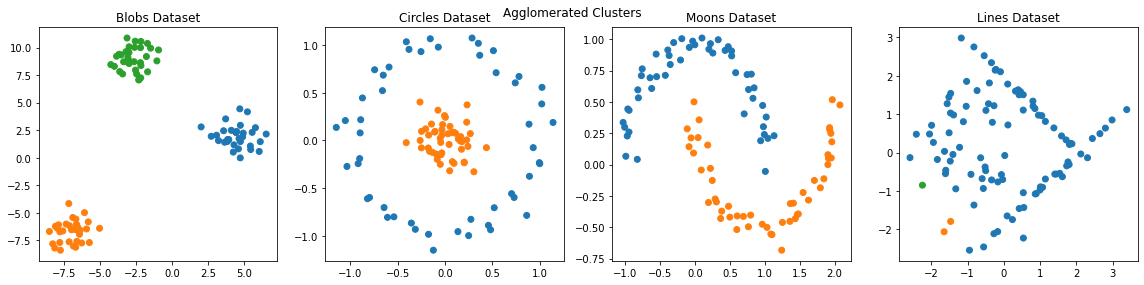

In [3]:
#@title Hierarchical Clustering Clusters
from sklearn.cluster import AgglomerativeClustering
plt_datasets(datasets,
             title='Agglomerated Clusters',
             plotter=lambda dataset, axis: dataset.plot_clusters(
                 AgglomerativeClustering(linkage='single', n_clusters=dataset.n_clusters),
                 axis))

The results seem much better. The second and third datasets' clustering results are looking pretty good! The fourth one, not so much, but we'll work on that one later.

Let's focus in on the details of the second plot to gain an intuition for the algorithm. It'll come in handy when you implement hierarchical clustering in the following sections.

Recall that agglomerative clustering successively merges the two "nearest" clusters until the desired number of clusters is reached. The following cell plots the algorithm's progress as five clusters are merged into the final two, as well as the resulting *dendrogram*.

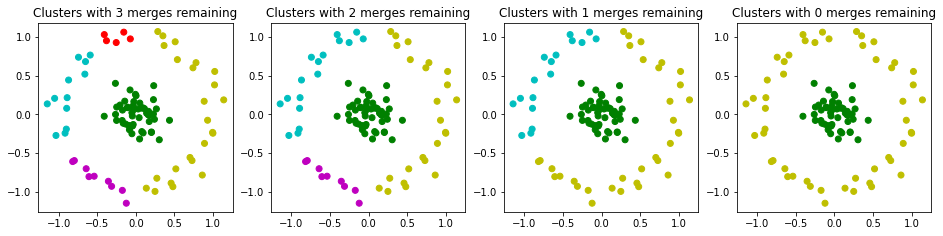

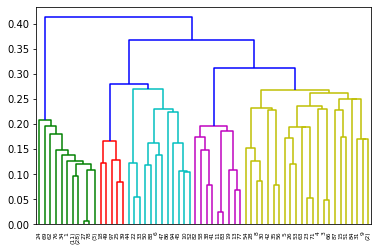

In [4]:
#@title Agglomerative clusters
import numpy as np
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering

def calc_linkage_matrix(clusterer):
    counts = np.zeros(clusterer.children_.shape[0])
    n_samples = len(clusterer.labels_)
    for i, merge in enumerate(clusterer.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    return np.column_stack(
        [clusterer.children_,  clusterer.distances_, counts]).astype(float)

clusterer = AgglomerativeClustering(distance_threshold=0.4, n_clusters=None, linkage='single')
clusterer.fit(circles_dataset.data)

linkage = calc_linkage_matrix(clusterer)

trees = hierarchy.cut_tree(linkage, n_clusters=list(range(5, 1, -1)))

nrows = 1
ncols = trees.shape[1] // nrows
fig, axes = plt.subplots(nrows=1,
                         ncols=trees.shape[1],
                         figsize=(4*trees.shape[1], 4))

DENDROGRAM_COLORS = np.array(['g', 'y', 'c', 'm', 'r'])
            
for i in range(trees.shape[1]):
    ax = axes[i]
    ax.set_aspect('equal')
    ax.scatter(circles_dataset.x, circles_dataset.y, c=DENDROGRAM_COLORS[trees[:, i]])
    ax.set_title(f'Clusters with {trees.shape[1] - i - 1} merges remaining')
plt.show()

hierarchy.dendrogram(linkage, truncate_mode='level', p=8, color_threshold=.28);

We see that the central circle is well classified early on: even with 3 merges remaining, the subtree in the dendrogram (green) requires no further merges. However, the outer circle, due to noise and sparsity has three extra clusters.

The first of the outer ring's clusters to be merged are red and cyan, which happens because they are the two clusters with points closest together (for some definition of _close_, which we will explore later). Next, yellow and magenta are merged, as we see as the third highest node in the dendrogram. Finally, the (merged) cyan and (merged) yellow clusters are merged, leaving us with the two clusters that we so greatly desire.

# Part 2: Implement Hierarchical Clustering

In this section, you will have the chance to implement both agglomerative and divisive clustering with the given interface. After finishing the implementation, you can verify the correctness of them through the interative demo and comparing the result with sklearn implementation. 

In [5]:
# import necessary packages
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from ipywidgets import interact, IntSlider
import ipywidgets as widgets
from typing import Dict, Set

We first provide the _Cluster_ class which represents a single cluster. Each cluster object has its unique cluster id, data points, and information of the closest cluster. We have defined all the attributes and methods of _Cluster_ class for you.

In [6]:
class Cluster:
    '''
	Class which defines a single cluster
	'''
    def __init__(self, cluster_id: int, data_indexes: Set[int]):
        '''
        Initialize the cluster with unique cluster id and corresponding data currently contained in the cluster
        '''
        self.id = cluster_id
        self.data_indexes = data_indexes
        self.min = (-1, np.inf)  # (id, dissimilarity)
    
    def merge(self, c: "Cluster"):
        '''
        Merges the data indexes in "c" into the current cluster
        '''
        self.data_indexes = self.data_indexes.union(c.data_indexes)

    def __len__(self):
        return len(self.data_indexes)


We then define _Clustering_ class which is the base class of agglomerative and divisive clustering algorithms. We have specified the attributes of this class. You need to implement two methods called *add_cluster* and *remove_cluster*.

In [7]:
class Clustering:
    '''
	Class inherited by different hierarchical clustering algorithms
	'''
    def __init__(self, data: np.ndarray):
        '''
        Initialize the clustering algorithm with all data points
        '''
        self.n_clusters = 0
        self.data = data
        self.n_data = data.shape[0]
        self.clusters: Dict[int, Cluster] = {}  # cluster_id: cluster
        self.dissimilarity_table = np.zeros((self.n_data, self.n_data))

    def add_cluster(self, cluster: Cluster):
        '''
        Add a single cluster object to the clustering algorithm
        '''
        ### Implementation Starts ###
        assert cluster.id not in self.clusters
        self.n_clusters += 1
        self.clusters[cluster.id] = cluster
        ### Implementation Ends ###

    def remove_cluster(self, cluster_id: int):
        '''
        Remove the cluster that has been merged by another cluster
        '''
        ### Implementation Starts ###
        if cluster_id in self.clusters:
            del self.clusters[cluster_id]
            self.n_clusters -= 1
        ### Implementation Ends ###


For simplicity, assume our data points are all with 2D. Please implement the affinity function and four different types of linkage functions below.  
We provide the formulas of affinity and linkage functions here.  
- Affinity: $d(x, y)=||x-y||_2$   

Assume two clusters $c1=\{a_1, a_2, \cdots, a_m\}; c2=\{b_1, b_2, \cdots, b_n\}$.  
- Single linkage: $d(c1,c2)=\min d(a_i, b_j)\qquad \forall i,j$
- Complete linkage: $d(c1,c2)=\max d(a_i, b_j)\qquad \forall i,j$
- Average linkage: $d(c1,c2)=\frac{1}{mn} \sum_{i}\sum_{j} d(a_i, b_j)$
- Ward linkage: $m1=\frac{1}{m}\sum_i a_i;\quad m2=\frac{1}{n}\sum_j b_j;\quad d(c1,c2)=\frac{mn}{m+n} d(m1, m2)^2$

In [8]:
def affinity(x, y):
    '''
    Return the Eclidian distance between two data points x and y (here we assume they are both 2D vector)
    '''
    ### Implementation Starts ###
    return np.linalg.norm(x - y)
    ### Implementation Ends ###


def single_linkage(c: Clustering, c1: Cluster, c2: Cluster, affinity_func=affinity):
    '''
    Return the single linkage dissimilarity
    '''
    ### Implementation Starts ###
    min_dissimilarity = np.inf
    for d1 in c1.data_indexes:
        for d2 in c2.data_indexes:
            min_dissimilarity = min(affinity_func(c.data[d1], c.data[d2]), min_dissimilarity)
    return min_dissimilarity
    ### Implementation Ends ###


def complete_linkage(c: Clustering, c1: Cluster, c2: Cluster, affinity_func=affinity):
    '''
    Return the complete linkage dissimilarity
    '''
    ### Implementation Starts ###
    max_dissimilarity = -np.inf
    for d1 in c1.data_indexes:
        for d2 in c2.data_indexes:
            max_dissimilarity = max(affinity_func(c.data[d1], c.data[d2]), max_dissimilarity)
    return max_dissimilarity
    ### Implementation Ends ###


def average_linkage(c: Clustering, c1: Cluster, c2: Cluster, affinity_func=affinity):
    '''
    Return the average linkage dissimilarity
    '''
    ### Implementation Starts ###
    dissimilarity_sum = 0
    for d1 in c1.data_indexes:
        for d2 in c2.data_indexes:
            dissimilarity_sum += affinity_func(c.data[d1], c.data[d2])
    return dissimilarity_sum / len(c1) / len(c2)
    ### Implementation Ends ###


def ward_linkage(c: Clustering, c1: Cluster, c2: Cluster, affinity_func=affinity):
    '''
    Return the ward linkage dissimilarity
    '''
    ### Implementation Starts ###
    m1 = np.mean(c.data[list(c1.data_indexes), :], axis = 0)
    m2 = np.mean(c.data[list(c2.data_indexes), :], axis = 0)
    return affinity_func(m1, m2)**2 * len(c1) * len(c2) / (len(c1) + len(c2))
    ### Implementation Ends ###


Use the following code block to check whether your implementation of linkage functions are correct. If you can pass the given cell, your linkage functions are likely to be correct. You may create more test cases by yourself. 

In [9]:
data = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
global_clustering = Clustering(data)
cluster1 = Cluster(0, set([0, 1]))
cluster2 = Cluster(1, set([2, 3]))
assert math.isclose(single_linkage(global_clustering, cluster1, cluster2), 2.8284, abs_tol=1e-4)
assert math.isclose(complete_linkage(global_clustering, cluster1, cluster2), 8.4852, abs_tol=1e-4)
assert math.isclose(average_linkage(global_clustering, cluster1, cluster2), 5.6568, abs_tol=1e-4)
assert math.isclose(ward_linkage(global_clustering, cluster1, cluster2), 32.0000, abs_tol=1e-4)

## Impelmentation of Agglomerative Clustering

We will then start to implement the agglomerative clustering algorithm. Fill in the function _find_minimum_pair_ and _merge_update_cluster_ below according to the given instructions. 

In [10]:
class AggClustering(Clustering):
    def __init__(self, data, linkage_func):
        super().__init__(data)
        '''
        Initialize agglomerative clustering with n separate clusters and initialize the 
        dissimilarity_table and nearest neighbour of each cluster
        '''
        self.linkage = linkage_func
        for i in range(self.n_data):
            self.add_cluster(Cluster(i, {i}))
        for i in self.clusters:
            for j in self.clusters:
                distance = self.linkage(self, self.clusters[i], self.clusters[j])
                self.dissimilarity_table[i, j] = distance
                if j!=i and distance < self.clusters[i].min[1]:
                    self.clusters[i].min = (j, distance)

    def find_minimum_pair(self):
        '''
        Find the pair of cluster with minimum dissimilarity
        Hint: you can take advantage of the 'min' attribute of each cluster
        ----
        Return: cluster_id of two clusters
        '''               
        ### Implementation Starts ###
        min_pair = (-1, -1, np.inf)
        for i, cluster in self.clusters.items():
            if cluster.min[1] < min_pair[2]:
                min_pair = (i, cluster.min[0], cluster.min[1])
        return min_pair[0], min_pair[1]
        ### Implementation Ends ###

    def merge_update_cluster(self, target_id: int, victim_id: int):
        '''
        This function need to deal with three tasks
            1. Merge the cluster with id victim_id into the cluster with id target_id
            2. Update the dissimilarity matrix elements related to the victim cluster 
               Hint: change the values to be np.inf
            3. Update the closest neighbour of each cluster
        '''
        ### Implementation Starts ###
        # Merge victim into target
        victim_cluster = self.clusters.pop(victim_id)
        target_cluster = self.clusters[target_id]
        target_cluster.merge(victim_cluster)
        self.n_clusters -= 1

        # remove dissimilarity values related with victim
        self.dissimilarity_table[victim_id, :] = np.inf
        self.dissimilarity_table[:, victim_id] = np.inf

        # update dissimilarity values and neighbours
        for i in self.clusters.keys():
            dissimilarity = self.linkage(self, self.clusters[i], target_cluster)
            self.dissimilarity_table[i, target_id] = dissimilarity
            self.dissimilarity_table[target_id, i] = dissimilarity
        for i in self.clusters.keys():
            self.dissimilarity_table[i, i] = np.inf  # avoid the current cluster regard itself as the closest cluster
            min_idx = np.argmin(self.dissimilarity_table[i, :])
            self.clusters[i].min = (min_idx, self.dissimilarity_table[i, min_idx])
        ### Implementation Ends ###


In [11]:
# code for interactive demo; no implementation needed
def plot_clustering(dataset, assignments):
    for i, indexes in assignments.items():
        plt.scatter(dataset[list(indexes), 0], dataset[list(indexes), 1])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


def interact_clustering(dataset, logger):
    history = list(logger)

    def plotter(i):
        plot_clustering(dataset, history[i])

    interact(plotter, i=IntSlider(min=0, max=len(history) - 1, continuous_update=False))


The psudocode of the main loop of Agglomerative clustering is as follows. 
```
for the number of clusters k decreases from n to 1 do
    Find the two clusters ci, cj with the smallest dissimilarity according to dissimilarity matrix;
    Merge ci with cj and update the dissimilarity matrix;
end for
```
Based on the psudocode, fill in the missing part in the main body of agglomerative clustering: _perform_agglomerative_clustering_ function.

In [12]:
def copy_cluster_assignments(clusters):
    assignments = {}
    for i, cluster in clusters.items():
        assignments[i] = cluster.data_indexes.copy()
    return assignments

def perform_agglomerative_clustering(n_cluster, dataset, linkage_func):
    clusters = AggClustering(dataset, linkage_func)
    while clusters.n_clusters > n_cluster:
        yield copy_cluster_assignments(clusters.clusters)
        ### Implementation Starts ###
        id1, id2 = clusters.find_minimum_pair()
        clusters.merge_update_cluster(id1, id2)
        ### Implementation Ends ###
    yield copy_cluster_assignments(clusters.clusters)

def final_agglomerative_clustering(n_cluster, dataset, linkage_func):
    out = list(perform_agglomerative_clustering(n_cluster, dataset, linkage_func))
    return out[-1]

After implementing all the functions above, we can enjoy the following interactive plot. Adjust *num* and *linkage_func* and compare different linkage functions.

In [13]:
num = 10
dataset = np.random.rand(num, 2)
interact_clustering(dataset, perform_agglomerative_clustering(1, dataset, single_linkage))

interactive(children=(IntSlider(value=0, continuous_update=False, description='i', max=9), Output()), _dom_cla…

If you find your implementation work correctly on the above toy examples, you can validate the implementation on larger cases by comparing with Sklearn's Agglomerative Clustering function below. Feel free to try out different number of clusters, linkage functions, etc.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


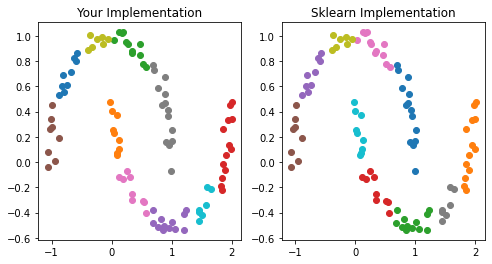

In [14]:
from sklearn.datasets import make_moons
from sklearn.cluster import AgglomerativeClustering
# generate dataset
moons_dataset = Dataset(make_moons(noise=0.05)[0], 'Moons', 2)
dataset = np.vstack((moons_dataset.x, moons_dataset.y)).T

linkage_mapping = {'ward': ward_linkage, 'single': single_linkage, 'complete': complete_linkage, 'average': average_linkage}

def plot_and_compare(n_clusters, dataset, linkage="ward"):
    result = final_agglomerative_clustering(n_clusters, dataset, linkage_mapping[linkage])
    labels = AgglomerativeClustering(n_clusters = n_clusters, linkage = linkage).fit(dataset)

    def visualize_clusters(axis, data, labels, title):
        cluster_labels = set(labels)
        for i in cluster_labels:
            axis.scatter(data[labels == i][:, 0], data[labels == i][:, 1])
        axis.set(title=title)
    
    def plot_clustering(axis, dataset, assignments, title):
        for i, indexes in assignments.items():
            axis.scatter(dataset[list(indexes), 0], dataset[list(indexes), 1])
        axis.set(title=title)
    
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    plot_clustering(ax1, dataset, result, "Your Implementation")
    visualize_clusters(ax2, dataset, labels.labels_, "Sklearn Implementation")
    fig.show()

# change the n_clusters value and linkage function here to better compare the clustering results
plot_and_compare(n_clusters=10, dataset=dataset, linkage="average")

Congratulations, you have successfully finished this part.

## Impelmentation of Divisive Clustering

After finishing the agglomerative clustering, it is also a good exercise to implement the divisive clustering. Divisive clustering is a more challenging task compared to the agglomerative one, so we will provide more starter code for you.   
As a reference, pseudocode of desired implementation is provided here. Notice that in order to simplify the implementation, when deciding whether an object belongs to the splinter class or the original class, we will not use a while loop to put objects to the splinter class one point at a time, but add all the points with positive delta value to splinter class at once. This will cause differences in outcome when compared with the original algorithm.
```
for the number of clusters k increases from 1 to n do
    Choose the cluster Ci with the largest diameter value;
    Within Ci, choose the object that has the maximum distance with the other objects as the splinter cluster;
    Split splinter cluster and original cluster;
    for each data point j in Ci do
        Calculate the distance d1 between the data j and the other objects in Ci as one cluster;
        Calculate the distance d2 between the data j and the splinter cluster;
        Calculate the difference \delta dj=d1−d2;
    end for
    Move the data j with positive \delta dj to the splinter cluster and update Ci;
end for
```

In [15]:
class DivisiveClustering(Clustering):
    def __init__(self, data):
        '''
        Initialize divisive clustering with 1 entire clusters and dissimilarity_table
        '''
        super().__init__(data)
        self.last_index = 2 * self.n_data
        self.add_cluster(Cluster(self.last_index, set(range(self.n_data))))
        temp_clusters = {}
        for i in range(self.n_data):
            temp_clusters[i] = Cluster(i, {i})
        for i in range(self.n_data):
            for j in range(self.n_data):
                distance = affinity(self.data[i], self.data[j])
                self.dissimilarity_table[i, j] = distance
        for i in range(self.n_data):
            self.dissimilarity_table[i, i] = 0

    def splinter(self):
        '''
        1. Find the cluster with largest diameter
        2. Find the splinter element (point inside the cluster with maximum average distance w.r.t others)
        ---
        Return: splinter element, max diameter cluster's id
        '''
        # Find cluster with largest diameter
        max_diameter_cluster_id = -1
        max_diameter = -np.inf
        for id, cluster in self.clusters.items():
            ### Implementation Starts ###
            if len(cluster) < 1:
                diameter = -1
            else:
                data_index_list = list(cluster.data_indexes)
                diameter = np.max(self.dissimilarity_table[np.ix_(data_index_list, data_index_list)])
            if diameter > max_diameter:
                max_diameter_cluster_id = id
                max_diameter = diameter
            ### Implementation Ends ###

        max_diameter_cluster = self.clusters[max_diameter_cluster_id]

        # Find the splinter element
        splinter_element = -1
        max_avg_within_cluster_distance = -np.inf
        data_indexes = list(max_diameter_cluster.data_indexes)
        for pt in data_indexes:
            # Calculate the total distance between pt and other points in cluster
            ### Implementation Starts ###           
            cluster_distance = np.sum(self.dissimilarity_table[np.ix_(data_indexes, [pt])])
            ### Implementation Ends ###
            avg_within_cluster_distance = cluster_distance / (len(max_diameter_cluster) - 1)
            if avg_within_cluster_distance > max_avg_within_cluster_distance:
                splinter_element = pt
                max_avg_within_cluster_distance = avg_within_cluster_distance
        return splinter_element, max_diameter_cluster_id
        

    def reassign(self, splinter_element, orig_cluster_key):
        '''
        1. Judge whether other data points inside the target cluster belongs to splinter group
        2. Split the cluster
        '''
        # Remove the splinter element from the original cluster
        temp_new_cluster = Cluster(0, {splinter_element})
        self.clusters[orig_cluster_key].data_indexes.remove(splinter_element)
        temp_orig_cluster = self.clusters[orig_cluster_key]

        # Remove orig cluster from cluster dict
        self.remove_cluster(orig_cluster_key)

        # Calculate distances d1, d2 and \delta d for all data points in temp_orig_cluster
        ### Implementation Starts ###
        data_indexes = list(temp_orig_cluster.data_indexes)
        within_cluster_dist = {pt: np.mean(self.dissimilarity_table[np.ix_(data_indexes, [pt])]) for pt in
                               data_indexes}
        dist_to_splinter = {pt: self.dissimilarity_table[pt, splinter_element] for pt in data_indexes}
        dist_diff = {pt: (within_cluster_dist[pt] - dist_to_splinter[pt]) for pt in
                     data_indexes}  # if +ve, move to splinter
        ### Implementation Ends ###

        # Reassign points
        for pt in data_indexes:
            if dist_diff[pt] > 0 and len(temp_orig_cluster) > 2:
                temp_new_cluster.data_indexes.add(pt)
                temp_orig_cluster.data_indexes.remove(pt)

        # Add temp clusters to cluster dict
        if len(temp_orig_cluster) > 0:
            if len(temp_orig_cluster) == 1:
                temp_orig_cluster.id = list(temp_orig_cluster.data_indexes)[0]
            else:
                self.last_index -= 1
                temp_orig_cluster.id = self.last_index
            self.add_cluster(temp_orig_cluster)

        if len(temp_new_cluster) > 0:
            if len(temp_new_cluster) == 1:
                temp_new_cluster.id = list(temp_new_cluster.data_indexes)[0]
            else:
                self.last_index -= 1
                temp_new_cluster.id = self.last_index
            self.add_cluster(temp_new_cluster)


Fill in the missing parts of the main body of divisive clustering.

In [16]:
def perform_divisive_clustering(n_cluster, dataset):
    clustering = DivisiveClustering(dataset)
    while clustering.n_clusters < n_cluster:
        yield copy_cluster_assignments(clustering.clusters)
        ### Implementation Starts ###
        splinter_element, orig_cluster_key = clustering.splinter()
        clustering.reassign(splinter_element, orig_cluster_key)
        ### Implementation Ends ###
    yield copy_cluster_assignments(clustering.clusters)


In [17]:
num = 10
dataset = np.random.rand(num, 2)
interact_clustering(dataset, perform_divisive_clustering(8, dataset))

interactive(children=(IntSlider(value=0, continuous_update=False, description='i', max=7), Output()), _dom_cla…

# Part 3: Explore Agglomerative Clustering Hyperparameters

Now you have obtained a better understanding of how agglomerative and divisive clustering works, and you can also see that the time complexity of hierarchical clustering algorithms are quite high. In practical settings, you seldom need to implement the algorithm from scratch. Even when you do that, you will be able to realize a more efficient version of the algorithm with priority queue (a useful data structure that you will soon encounter in the following weeks of CS61B).   
In practical cases, you will use Sklearn [Agglomerative Clustering function](https://sklearn.cluster.AgglomerativeClustering) or scipy [linkage function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html). They can both perform agglomerative clustering, but each of them has its own advantage over the other.  Sklearn's AgglomerativeClustering is more convenient to directly visualize final clustering results, while scipy's linkage function is better at demostrating the dendrogram (the linkage process).  
In this sections, we will take advantage of sklearn's AgglomerativeClustering to demo various possibilities of setting hyperparameters.

## Tuning linkage function

In practical setting, when you wish to apply agglomerative clustering, you need to pick the most approperiate clustering function. As for Sklearn Agglomerative Clustering, choices are single linkage, complete linkage, average linkage, and ward linkage. Different linkage function will be useful for different types/shapes of clusters. For each of the toy examples below, try to cluster them with different linkage functions, state your observation, decide for the most apprioriate linkage function, and explain why you make this choice and the underlying reasons.  

In [18]:
from sklearn.cluster import AgglomerativeClustering

In [19]:
def visualize_clusters(data, labels):
    cluster_labels = set(labels)
    for i in cluster_labels:
        plt.scatter(data[labels == i][:, 0], data[labels == i][:, 1])
    plt.gca().set_aspect('equal', adjustable='box')

**Case 1:**

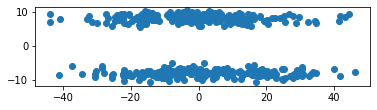

In [20]:
np.random.seed(101)
classA = np.random.randn(200, 2) * np.array([[16, 1]]) + np.array([[0, 8]])
classB = np.random.randn(200, 2) * np.array([[16, 1]]) + np.array([[0, -8]])
data = np.concatenate((classA, classB), axis = 0)
plt.scatter(data[:,0], data[:,1])
plt.gca().set_aspect('equal', adjustable='box')

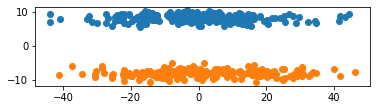

In [21]:
# Fill in *n_cluster* and *linkage* below
result = AgglomerativeClustering(n_clusters = 2, linkage = 'single').fit(data)
visualize_clusters(data, result.labels_)

Observation and Explanation Starts Here

Answer: Single linkage is the best choice here. Unlike average, ward, and complete linkage which considers intra-cluster distance, single linkage is very local. It only considers the closest two points over two clusters, but ignore all other points of the cluster. It is good at clustering non-spherical or separated clusters. In the above elongated cluster case, single linkage can have the best performance.  

**Case 2:**

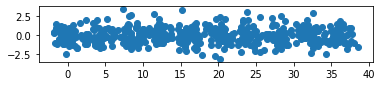

In [22]:
np.random.seed(100)
data = np.random.multivariate_normal(np.array([0, 0]), np.array([[1, 0], [0, 1]]), 50)
for i in range(1, 10):
    new_group = np.random.multivariate_normal(np.array([4 * i, 0]), np.array([[1, 0], [0, 1]]), 50)
    data = np.concatenate((data, new_group), axis = 0)
plt.scatter(data[:,0], data[:,1])
plt.gca().set_aspect('equal', adjustable='box');

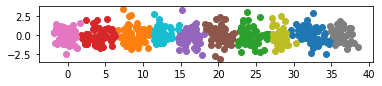

In [23]:
# Fill in *n_cluster* and *linkage* below
result = AgglomerativeClustering(n_clusters = 10, linkage = 'ward').fit(data)
visualize_clusters(data, result.labels_)

Observation and Explanation Starts Here  
Answer: Complete, average, and ward linkage function can all perform well in this case here, since all of them are good at clustering compact equal size clusters. However, single linkage function will lead to suboptimal results by clustering most of the points as one cluster, and leave each outlier point as separate clusters.



Case 3:

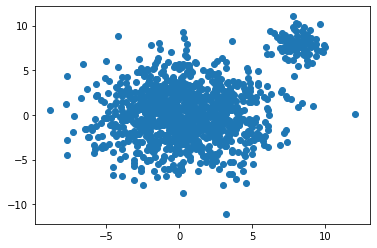

In [24]:
np.random.seed(101)
group1 = np.random.multivariate_normal(np.array([0, 0]), np.array([[8, 0], [0, 8]]), 1000)
group2 = np.random.multivariate_normal(np.array([8, 8]), np.array([[1, 0], [0, 1]]), 100)
data = np.concatenate((group1, group2), axis = 0)
plt.scatter(data[:,0], data[:,1]);

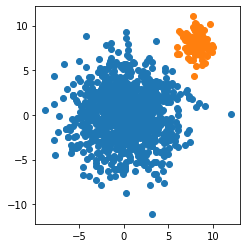

In [25]:
# Fill in *n_cluster* and *linkage* below
result = AgglomerativeClustering(n_clusters = 2, linkage = 'ward').fit(data)
visualize_clusters(data, result.labels_)

Observation and Explanation Starts Here   
Answer: The most suitable choice is the ward linkage function. Ward linkage function tends to form compact clusters and minimize the variance inside the clusters. Complete linkage is not suitable here because as you can observe, it tends to form clusters with equal diameter, so it will split the larger cluster into two halves. Single linkage and average linkage in this example are suffering from two outliers points in the bottom, so they also fail to give satisfactory clustering results. 

## Choose Appropriate Affinity Function



In many cases, the default Euclidean distance function is no longer appropriate in depicting the dissimilarity between two data points. For the following case, image that we wish to cluster the fan-shaped dataset into three equal radian sectors. Explore different affinity metric to achieve the desired result. 

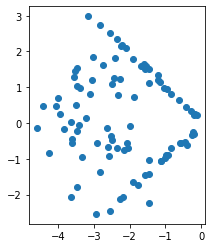

In [26]:
from sklearn.datasets import make_classification
lines_dataset = Dataset(make_classification(n_features=2, n_redundant=0, random_state=4242)[0], 'Lines', 3)
dataset = np.vstack((lines_dataset.x, lines_dataset.y)).T
dataset = dataset[dataset[:,0]<2] + [-2, 0]
plt.scatter(dataset[:,0], dataset[:,1])
plt.gca().set_aspect('equal', adjustable='box');

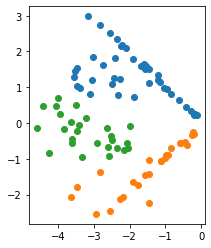

In [27]:
# Fill in *affinity* below
result = AgglomerativeClustering(n_clusters = 3, linkage = 'complete', affinity='cosine').fit(dataset)
visualize_clusters(dataset, result.labels_)

# Part 4: Practical Application

Finally, you will have the chance to apply clustering in some more practical settings.

## How Many Beacons? 

We start with a setting that you are already familiar with in ee16a lectures and labs. In APS lab, you are required to determine the distance between your receiver and different beacons.   
Now we change the setting by a little bit. You have collected a bunch of equal length signals, transmitted from an unknown number of beacons. Although you have no idea how each beacon signal looks like, you know that they are different and each received signal only contains one beacon pattern rather than an interleaving of multiple beacon patterns. Received signal from a beacon may be delayed by different timestamps and corrupted with noise.  
Load the `signals.pkl` dataset, ignore the `beacon` column which states the ground truth labels, cluster the unlabelled signals using agglomerative clustering, and report the clustering result as well as the number of different beacons.   
   
Guidelines:
You can follow the given steps to solve this problem. Since this is a practical setting problem, we will only provide you with necessary guidelines. Although some steps for solving this task have not been covered in course materials till now, you need to figure out how to realize them by reading function documentations and searhing for related resources online. In real working environment, the ability to read documentation and search for answers are really important.   

The guidelines are as follows.
- Load the `signals.pkl` dataset as a dataframe
- Define appropriate affinity function that correctly measures the similarity between signals 
- Apply Agglomerative Clustering with **self-defined** affinity definition and scipy linkage function
- Draw dendrogram to determine the number of clusters
- With the correct number of clusters, run Agglomerative Clustering again and compare the clustering results with ground truth labels
- Report your final result: is the clustering result same as the ground truth?


Hints and special notice:  
- If you have no idea about how to define the similarity or dissimiarilty metric between two signals, you may refer to [EECS16A APS Lab Introduction](https://eecs16a.org/lab/aps1.pdf) to refresh your memory.
- Since each signal are with high dimension, the clustering algorithm may need around 7-8 minutes to finish running

In [ ]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

### Start Your Code Below ###
# Compute max correlation as the similarity of two signals
def max_signal_correlation(signal1, signal2):
    doubled_signal1 = np.concatenate((signal1,signal1))
    corr_vec = np.correlate(doubled_signal1, signal2, 'full')
    return np.max(corr_vec[len(signal2)-1: len(signal2)-1 + len(signal2)])

# Define the dissimilarity between two signals
def dissimilarity(x, y): 
    return 1 / max_signal_correlation(x, y)

# Load the dataset
signal = pd.read_pickle("signal.pkl")

# Clustering and draw dendrogram
Z = linkage(np.vstack(signal['Signal']), metric=dissimilarity)
dn = dendrogram(Z)

From the dendrogram, by cutting at the largest similarity gap, we can see that it has 6 clusters in total, which confirms with the ground truth. Then we check the correctness of our clustering result.

In [ ]:
# gain the labels after deciding on the value of k
from sklearn.metrics import pairwise_distances
def signal_affinity(X):
    return pairwise_distances(X, metric=dissimilarity)

signal_labels = AgglomerativeClustering(n_clusters=6, affinity=signal_affinity, 
                                        linkage='average').fit(np.vstack(signal['Signal']))

In [ ]:
# check whether clustering result confirms with ground truth
for i in range(5):
    assert len(set(signal.iloc[signal_labels.labels_ == i]['Beacon'])) == 1

## Cluster Analysis of Bike Sharing System

In this part of the assignment, you will deal with real-life setting. You are given the citi-bike trip dataset, which records all the user trips in the New York citibike bikesharing system from Jan 1, 2017 to Jan 31, 2017. We hope that you can perform some open-ended clustering analysis for bike stations according to trip patterns.   

The requirements are as follows.
- The objects for clustering are bike stations.
- The analysis process/clustering criteria must involve user behavior or trip patterns. Simply use geographical distance to cluster stations is forbiddened.
- You need to do some visualization to confirm your result (e.g. use folium map). The visualization needs to clearly show all the bike station locations, clustering results, and supportive information.
- The total time for doing self-exploration is expected to be around 1-2 hours. The exploration process and results should be concisely demonstrated with over 5 cells of code and text explanations (over 50 lines of processing, clustering, and visualization code). We also highly encourge you to explore related researchs.

Before giving you the opportunity to do self exploration, we first gain more intuition about the dataset together.

In [28]:
import pandas as pd
import zipfile
import folium
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

with zipfile.ZipFile('citibike-tripdata.zip', 'r') as zip_ref:
    zip_ref.extractall()

trips = pd.read_csv('201701-citibike-tripdata.csv')

How many records are there in this dataset?  

In [29]:
# Write code to answer the question above
trips.shape

(726676, 15)

In [30]:
trips.head(n=3)

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender
0,680,2017-01-01 00:00:21,2017-01-01 00:11:41,3226,W 82 St & Central Park West,40.782750,-73.971370,3165,Central Park West & W 72 St,40.775794,-73.976206,25542,Subscriber,1965.0,2
1,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,3263,Cooper Square & E 7 St,40.729236,-73.990868,498,Broadway & W 32 St,40.748549,-73.988084,21136,Subscriber,1987.0,2
2,648,2017-01-01 00:00:57,2017-01-01 00:11:46,3143,5 Ave & E 78 St,40.776829,-73.963888,3152,3 Ave & E 71 St,40.768737,-73.961199,18147,Customer,NaN,0


By visualizing the first three records of this dataframe, we can see that this dataset records the trip duration (in seconds), trip start time, end time, start station, end station, bike id, whether the use is a subscribed use, user's age, and user's gender (1: male; 2: female). 

Since we need to do clustering analysis on bike stations, we analyze and visualize station information together. 

In [31]:
# extract the information of stations: containing station ID and the corresponding latitude, longitude
start_stations = trips[['Start Station ID', 'Start Station Latitude', 'Start Station Longitude']].rename(columns={
    'Start Station ID': 'Station ID', 'Start Station Latitude': 'Latitude', 'Start Station Longitude': 'Longitude'})
end_stations = trips[['End Station ID', 'End Station Latitude', 'End Station Longitude']].rename(columns={
    'End Station ID': 'Station ID', 'End Station Latitude': 'Latitude', 'End Station Longitude': 'Longitude'})

# Start your code here: concat start_stations and end_stations
stations = pd.concat([start_stations, end_stations])
# Start your code here: drop duplicates
stations = stations.drop_duplicates(subset = ['Station ID']).reset_index(drop=True)

Let's visualize station together.

In [32]:
map = folium.Map(location=[40.7, -73.9], zoom_start=12)
for index, row in stations.iterrows():
    folium.Circle(row[['Latitude', 'Longitude']].tolist(), 
                  popup=str(int(row['Station ID'])), radius=0.1).add_to(map)
map

Zoom in and out the resulting foilum map. What do you notice? Are there any abnormal stations? What are their station ID?  
Answer: There are a few abnormal stations, with id 3239, 255, 3245, 3183, 3040, 3036.  
Let's then sort the dataframe by lat/lon values and filter out all outliers.

In [33]:
stations.sort_values(by='Latitude')

,Station ID,Latitude,Longitude
608,3446,0.000000,0.000000
607,3036,40.517975,-74.031372
597,3239,40.646538,-74.016588
595,3245,40.646678,-74.016303
604,3040,40.646678,-74.016263
...,...,...,...
50,3343,40.799757,-73.962113
185,3357,40.800836,-73.966449
480,3331,40.801343,-73.971146
79,3366,40.802117,-73.968181


In [34]:
# Start your code here: remove these outliers and corresponding trips in trips
stations = stations[stations['Latitude']>40.65]
stations = stations[stations['Longitude']>-74.03]
station_ids = stations['Station ID'].tolist()
trips = trips[(trips['Start Station ID'].isin(station_ids)) & (trips['End Station ID'].isin(station_ids))]

Make sure that you have done everything correctly till this stage

In [35]:
assert stations.shape[0] == 605
assert trips.shape[0] == 726454

Then you can start your free exploration!

State the objective for you analysis here.  
**Objective Starts Here**  
...


This exercise do not have correct answer. So we just provide an example here. 
In this example, we aim to cluster bike stations into independent similar size clusters. We hope to minimize the number of trips across different clusters, so that each cluster can serve as a mini-system, in which operators can rebalance bikes or analyze total customer usage only inside each cluster.  

The entire travelling pattern may be chaotic and hard to be separated into several clusters, so we only pay attention to the travelling pattern in morning rush hours here. 

In [36]:
trips['Start Time'] = pd.to_datetime(trips['Start Time'], format="%Y-%m-%d %H:%M:%S")

In [37]:
trips['Start Hour'] = trips['Start Time'].dt.hour
trips['Day'] = trips['Start Time'].dt.weekday

In [38]:
morning_rush_hour_trips = trips[(trips['Start Hour'] >= 7) & (trips['Start Hour'] <= 9) &
                                (trips['Day'] <= 4)]

In [39]:
inter_station_counts = morning_rush_hour_trips.groupby(['Start Station ID', 'End Station ID'])['Trip Duration'].count()
inter_station_counts = inter_station_counts.to_dict()

In [40]:
stations = stations.set_index('Station ID')

Let's visualize station together with inter-station trip counts.


In [41]:
map = folium.Map(location=[40.7, -73.9], zoom_start=12)
for index, row in stations.iterrows():
    folium.Circle(row[['Latitude', 'Longitude']].tolist(), 
                  popup=str(int(index)), radius=0.1).add_to(map)
    for end_station, end_row in stations.iterrows():
        if end_station != index and ((index, end_station) in inter_station_counts or 
                                     (end_station, index) in inter_station_counts):
            count = 0
            if (index, end_station) in inter_station_counts:
                count += inter_station_counts[(index, end_station)]
            if (end_station, index) in inter_station_counts:
                count += inter_station_counts[(end_station, index)]
            if count > 30:
                points = [row[['Latitude', 'Longitude']].tolist(), end_row[['Latitude', 'Longitude']].tolist()]
                folium.PolyLine(points, color="red", weight=count/100, opacity=1).add_to(map)
map

From visualization, we can clearly see that two sides of the city separated by Hudson are clearly two clusters. Let's apply agglomerative clustering to do further analysis.

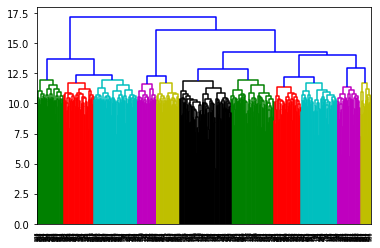

In [42]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
# Define the dissimilarity between two stations
# For any two stations, the dissimilarity is similar with the distance + alpha/inter_trip_count
def station_dissimilarity(x, y): 
    r = 6371
    id1, lat1, lon1 = x
    id2, lat2, lon2 = y
    lat1, lat2 = np.radians(lat1), np.radians(lat2)
    lon1, lon2 = np.radians(lon1), np.radians(lon2)
    a =  np.sin(lat1) * np.sin(lat2) + np.cos(lat1) * np.cos(lat2) * np.cos(lon1 - lon2)  
    c = np.arccos(a)      
    count = 0
    try:
         count += inter_station_counts[(int(id1), int(id2))]
         count += inter_station_counts[(int(id2), int(id1))] 
    except:
        pass
    return r*c + 10/np.exp(count/200) # Here we set alpha to 10 to emphasize the importance of trip counts

# Clustering and draw dendrogram
Z = linkage(np.vstack(stations.reset_index().to_numpy()), metric=station_dissimilarity, method='average')
dn = dendrogram(Z)

The maximum gap corresponds to when there are only three clusters. In order to obtain smaller clusters, we can cut at the second largest dissimilarity gap, so k=6.

In [ ]:
from sklearn.metrics import pairwise_distances
def station_affinity(X):
    return pairwise_distances(X, metric=station_dissimilarity)

station_labels = AgglomerativeClustering(n_clusters=6, affinity=station_affinity, 
                                        linkage='average').fit(np.vstack(stations.reset_index().to_numpy()))
stations['label'] = station_labels.labels_

In [ ]:
map = folium.Map(location=[40.7, -73.9], zoom_start=12)
colmap = {0: 'black', 1: 'rosybrown', 2: 'blue', 3: 'red', 4: 'green', 
          5: 'blueviolet', 6: 'indigo', 7: 'orchid', 8: 'orange', 9: 'plum'}
for index, row in stations.iterrows():
    folium.Circle(row[['Latitude', 'Longitude']].tolist(), 
                  popup=str(int(index)), radius=0.1, color=colmap[row['label']]).add_to(map)
    for end_station, end_row in stations.iterrows():
        if end_station != index and ((index, end_station) in inter_station_counts or 
                                     (end_station, index) in inter_station_counts):
            count = 0
            if (index, end_station) in inter_station_counts:
                count += inter_station_counts[(index, end_station)]
            if (end_station, index) in inter_station_counts:
                count += inter_station_counts[(end_station, index)]
            if count > 30:
                points = [row[['Latitude', 'Longitude']].tolist(), end_row[['Latitude', 'Longitude']].tolist()]
                folium.PolyLine(points, color="lightgreen", weight=count/100, opacity=1).add_to(map)
map

Congratulations! You have finished this homework. Now you are familiar with hierarchical clustering and the corresponding applications. You will get to know more clustering algorithm in other topics of this week. 

# References:

Bikesharing dataset: https://www.kaggle.com/andytran11996/citibike-dataset-2017?select=201701-citibike-tripdata.csv  